The goal is to build a graph to cluster the companies based on their similarity. We ended up with 9034 features, most of them being indicator variable.

Different clustering approaches:
* Direct clustering with unsupervised methods: k-means. An investigation may be done to to tune the number of clusters k
* Latent features models (mixture models; dimensionality reduction (NMF, PCA) and then use a distance matrix on computed features)
* Exploitation of a distance (or imilarity) matrix between the companies (n_companies square matrix), with the  euclidean distance (or the cosine) as our features are all numerical.

Definition of the cosine:

$$ \text{similarity} = \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$

where $A_i$ and $B_i$ are components of vector $A$ and $B$ respectively.

Based on these matrices, we can provide the nearest neighbors for a given entry.


We can use a multi-dimensional scaling to find an optimized lower dimensionality representation of the data (2D or 3D may be helpful for a nice vizualisation). This algorithm needs a lot of time to run, we tried it on a sub-sample of the data.



In [55]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import datetime
import time

In [66]:
# Loading the data
df = pd.read_csv("tmp/df.csv", index_col='Unnamed: 0')

/usr/local/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [67]:
# Need to have numerical features only
df['year_founded'] = df['month_founded'].str[:4]
df['month_founded'] = df['month_founded'].str[-2:]

In [68]:
df[['month_founded', 'year_founded']] = df[['month_founded', 'year_founded']].astype(int)

In [107]:
# cleaning the dataframe
df_clean = df.copy()
df_clean = df_clean.drop(['success', 'at_least_4_funding_rounds' , 'acquired_by', 'investors', 'funding_dates', 'text_nouns', 'text_adjectives', 'short_description', 'funding_amounts', 'founder_ages', 'ipo', 'funding_rounds'], axis=1)
df_clean = df_clean.drop(['acquisitions', 'board_members_and_advisors', 'founders', 'offices', 'headquarters', 'founder_names', 'moonth_founded'], axis=1)

# The columns competitors and categories should be helpful to create similarity, we could use them as additional weights.
competitors = df_clean[['competitors']]
categories = df_clean[['categories']]

df_clean = df_clean.drop(['categories', 'competitors'], axis=1)
# Too many missing values
df_clean = df_clean.drop(['founder_ages_mean'], axis=1)
# Reject NaN value (concerns funding_mean values)
df_clean = df_clean.dropna(how='any')

In [ ]:
# Need to standardize the numerical features to make them comparable to the binary one


In [108]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6626 entries, objectway to lodo-software
Columns: 9015 entries, month_founded to year_founded
dtypes: bool(9006), float64(2), int64(7)
memory usage: 57.4+ MB


## Dimensionality Reduction

We will try two main approaches to reduce the dimension of the features space:
* PCA
* NMF

In [109]:
from  sklearn.decomposition import PCA

# We keep 99% of the variance
pca = PCA(n_components=0.99)
%time X_pca = pca.fit_transform(df_clean)

print('PCA reduced the dimension from {} to {}'.format(df_clean.shape[1], pca.n_components_))

CPU times: user 9min 19s, sys: 11.1 s, total: 9min 30s
Wall time: 4min 35s
PCA reduced the dimension from 9015 to 2


In [111]:
from sklearn.decomposition import NMF
# Need to chose the dimension
dimension = 3

nmf = NMF(dimension ,max_iter=2000)
%time X_nmf = nmf.fit_transform(df_clean)

CPU times: user 8.51 s, sys: 1.65 s, total: 10.2 s
Wall time: 7.94 s


## Spatial Representation

We obtained a 3d representation of the data from the NMF. We could try to plot it to see if we can identify clusters.

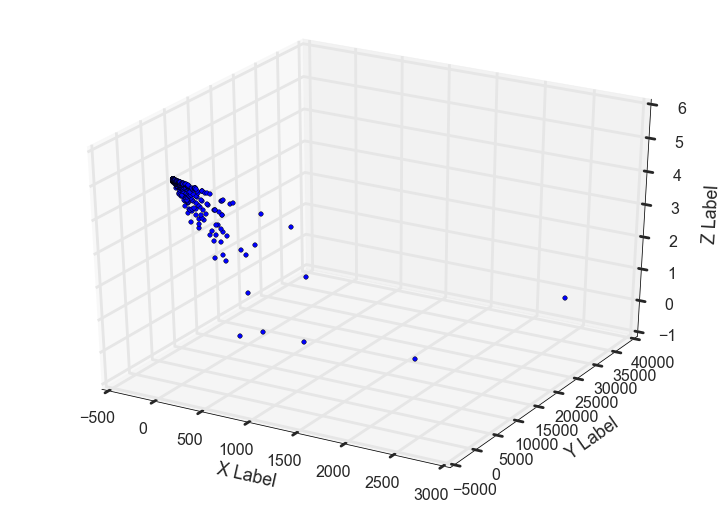

In [112]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
for c in X_nmf[:500, :]:
    ax.scatter(c[0], c[1], c[2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


## Distance Matrix

We compute the distance matrix from the _euclidean norm_

In [113]:
from sklearn.metrics.pairwise import pairwise_distances

In [117]:
distance_x = pairwise_distances(df_clean.values)

In [118]:
distance_X_pca = pairwise_distances(X_pca)

In [119]:
distance_X_nmf = pairwise_distances(X_nmf)

For a given entry, we can get its n closest neighbors now:

In [150]:
# Retrieving the mapping permalink2index
permalink2index = {k:i for i, k in enumerate(df_clean.index)}
index2permalink = {i:k for i, k in enumerate(df_clean.index)}

In [151]:
def get_neighbors(permalink, distance_matrix, permalink2index, index2permalink, n=5):
    permalink_index = permalink2index[permalink]
    neighbors_indexes = np.argsort(distance_matrix[permalink_index, :])[1:n+1]
    return [index2permalink[i] for i in neighbors_indexes]
    

In [152]:
get_neighbors('paypal', distance_x, permalink2index, index2permalink, n=5)

['plastic-logic', 'actifio', 'cheyipai', 'brightcove', 'cloudflare']

In [153]:
get_neighbors('paypal', distance_X_nmf, permalink2index, index2permalink, n=5)

['plastic-logic',
 'smartdrive-systems',
 'aquantia',
 'castlight-health',
 'zocdoc']

In [154]:
get_neighbors('paypal', distance_X_pca, permalink2index, index2permalink, n=5)

['plastic-logic', 'actifio', 'cheyipai', 'brightcove', 'cloudflare']

## Multi-dimensional scaling

This algorithm takes a lot of time to run, we executed it on a sub-sample of the data to see how it clusters them.

In [12]:
from sklearn.manifold import MDS

In [64]:
%%time
mds = MDS()
mds_X = mds.fit_transform(distance_X_pca[:500, :500])

CPU times: user 7.79 s, sys: 1.06 s, total: 8.85 s
Wall time: 8.08 s


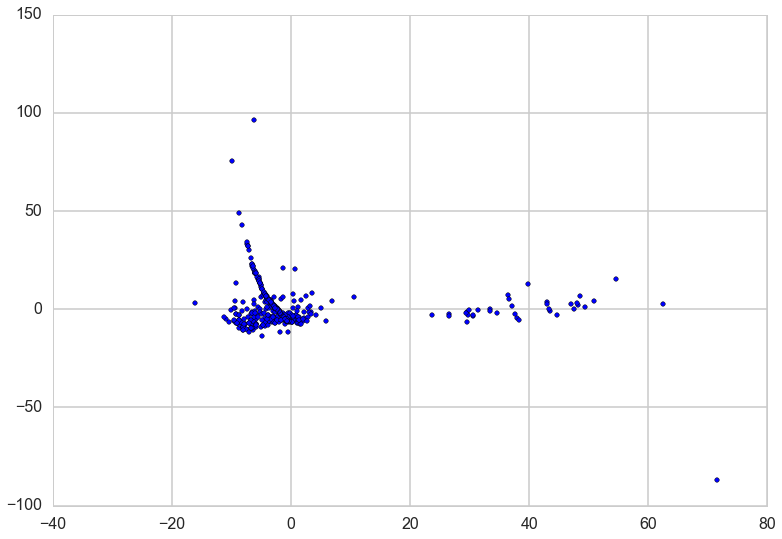

In [65]:
plt.scatter(mds_X[:, 0], mds_X[:, 1])

## k-Means

We run a k-Means algorithm. For the moment, the value of k is chosed. We can think later about a way to find an optimized value. We could try the method described in sklearn http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html. But first we need to find a way toe xtracte more accurate information from the data

The first results are not convincing since most of the entries are grouped in the same cluster. This may due to the fact that the features don't seem to be really discriminative. They are indeed highly sparse.

In [144]:
from sklearn.cluster import KMeans

In [145]:
%%time
km = KMeans(n_clusters=50)
X_km = km.fit_predict(df_clean)

CPU times: user 6min 10s, sys: 5 s, total: 6min 15s
Wall time: 4min 36s


In [146]:
%%time
km_pca = KMeans(n_clusters=80)
X_km_pca = km_pca.fit_predict(X_pca)

CPU times: user 1.07 s, sys: 119 ms, total: 1.19 s
Wall time: 1.11 s


In [147]:
import collections
clusters_counter = collections.Counter(X_km)
clusters_counter_pca = collections.Counter(X_km_pca)

In [148]:
print clusters_counter
print clusters_counter_pca

Counter({0: 3285, 37: 1088, 15: 614, 38: 327, 7: 200, 40: 170, 35: 167, 27: 96, 17: 76, 19: 75, 42: 64, 3: 51, 47: 51, 49: 41, 45: 40, 12: 35, 21: 26, 28: 24, 48: 21, 36: 20, 14: 17, 33: 17, 25: 15, 20: 14, 6: 12, 30: 11, 9: 8, 13: 8, 34: 6, 39: 5, 2: 4, 8: 4, 31: 4, 41: 4, 23: 3, 29: 3, 11: 2, 16: 2, 22: 2, 26: 2, 43: 2, 44: 2, 1: 1, 4: 1, 5: 1, 10: 1, 18: 1, 24: 1, 32: 1, 46: 1})
Counter({64: 2349, 0: 944, 69: 599, 28: 493, 19: 263, 62: 192, 53: 179, 77: 176, 47: 139, 52: 124, 43: 122, 22: 93, 79: 84, 11: 63, 42: 62, 56: 61, 54: 60, 33: 52, 73: 50, 44: 44, 13: 43, 34: 40, 78: 40, 25: 35, 68: 29, 39: 23, 4: 21, 16: 20, 36: 20, 27: 16, 59: 15, 7: 13, 38: 11, 61: 11, 58: 10, 10: 8, 70: 8, 24: 7, 40: 7, 45: 7, 76: 7, 18: 6, 37: 6, 74: 6, 75: 6, 57: 5, 35: 4, 50: 4, 2: 3, 31: 3, 32: 3, 55: 3, 12: 2, 14: 2, 17: 2, 20: 2, 23: 2, 30: 2, 48: 2, 49: 2, 71: 2, 1: 1, 3: 1, 5: 1, 6: 1, 8: 1, 9: 1, 15: 1, 21: 1, 26: 1, 29: 1, 41: 1, 46: 1, 51: 1, 60: 1, 63: 1, 65: 1, 66: 1, 67: 1, 72: 1})


In [160]:
# Cluster example
num_cluster = 56
cluster_members = [index2permalink[c] for c in np.arange(len(X_km_pca))[X_km_pca == num_cluster]]
print cluster_members

['pyramid-analytics', 'oberon-media', 'ak-networks', 'novadigm-therapeutics', 'euthymics-bioscience', 'greenwave-reality', 'riskiq', 'ipg', 'movius-interactive', 'travelbird', 'bolt-threads', 'hatteras-networks', 'userzoom', 'gogold-resources', 'local-matters', 'agilone', 'definiens', 'huy-vietnam', 'menlook', 'myalert', 'mzinga', 'careland', 'acacia-pharma', 'neteffect', 'kenandy', 'wetpaint', 'steelwedge-software', 'ce-info-systems', 'devialet', 'ibiquity-digital-corporation', 'arcot-systems', 'cash4gold', 'nextvr', 'proacta', 'angioscore', 'sequana-medical', 'mainstay-medical', 'neoguide-systems', 'tervela', 'lightinthebox-com', 'rakuten', 'financial-information-network-operations-pvt', 'picolight', 'coherex-medical', 'enforta', 'ewireless', 'eos-energy-storgae', 'ac-immune-sa', 'silverpop', 'world-wide-packets', 'oryzon-genomics', 'analogix-semiconductor', 'university-of-wollongong', 'globallogic', 'synthetic-genomics', 'innfocus-inc', 'invensense', 'mediamind', 'stentys', 'rockmel

In [161]:
# Cluster example
num_cluster = 59
cluster_members = [index2permalink[c] for c in np.arange(len(X_km_pca))[X_km_pca == num_cluster]]
print cluster_members

['ucb-pharma', 'intra-cellular-therapies', 'cogentus-pharmaceuticals', 'ulmart', 'calix', 'pernix-therapeutics-inc', 'gt-advanced-technologies', 'big-fish-games', 'funplus-game', 'glycomimetics', 'iqms', 'ganymed-pharmaceuticals', 'vocalcom', 'azul-systems', 'icon']


In [162]:
# Cluster example
num_cluster = 61
cluster_members = [index2permalink[c] for c in np.arange(len(X_km_pca))[X_km_pca == num_cluster]]
print cluster_members

['castlight-health', 'paypal', 'mapr-technologies', 'cheyipai', 'cloudflare', 'smartdrive-systems', 'kingdee', 'plastic-logic', 'trevena', 'aquantia', 'borro']


The first results are hard to evaluate. One issue is that the features have the same weight, for instance the country, the categories or the funding information are treated evenly. Maybe we should stree the categories. 

We could try to modify this weight or also to use the list competitors and categories to adjust the clusters.